# Project 3: Predicting new Airbnb users' first destinations
# Part 2: SQL and EDA

## Using SQL to perform some EDA

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import datetime as dt
import numpy as np
import pickle

%matplotlib inline

from sqlalchemy import create_engine
cnx = create_engine('postgresql://emilygeller:p@54.173.47.58:5432/emilygeller')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
pd.read_sql('select * from countries;', cnx)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [3]:
pd.read_sql('select * from sessions limit 5;', cnx)

,id,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,0,d1mm9tcy42,lookup,None,None,Windows Desktop,319.0
1,1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,2,d1mm9tcy42,lookup,None,None,Windows Desktop,301.0
3,3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,4,d1mm9tcy42,lookup,None,None,Windows Desktop,435.0


## Constructing features from Sessions data
I'll use SQL to build them.

### Total sessions per user

In [6]:
q = '''
select user_id, count(1)
from sessions
group by user_id
limit 5;'''

In [7]:
pd.read_sql(q,cnx)

,user_id,count
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789


In [13]:
q = '''
select user_id, count(1)
from sessions
group by user_id
;'''

In [14]:
total_sessions = pd.read_sql(q,cnx)

### Total sessions per user per device

In [15]:
q = '''
select sessions.user_id, sessions.total as Mac
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Mac Desktop'
    group by user_id, device_type) sessions

    ;'''

In [16]:
sessions_per_device = pd.read_sql(q,cnx)

In [17]:
q = '''
select sessions.user_id, sessions.total as Windows
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Windows Desktop'
    group by user_id, device_type) sessions

    ;'''

In [18]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [19]:
q = '''
select sessions.user_id, sessions.total as iPhone
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'iPhone'
    group by user_id, device_type
    ) sessions

    ;'''

In [20]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [21]:
q = '''
select sessions.user_id, sessions.total as Android
from (
    select user_id, device_type, count(1) total
    from sessions
    where device_type = 'Android'
    group by user_id, device_type
    ) sessions

    ;'''

In [22]:
sessions_per_device = sessions_per_device.merge(pd.read_sql(q,cnx), on = 'user_id', how = 'outer')

In [23]:
sessions_per_device = sessions_per_device.fillna(0)

In [24]:
sessions_per_device.head()

,user_id,mac,windows,iphone,android
0,00023iyk9l,36.0,0.0,4.0,0
1,0010k6l0om,63.0,0.0,0.0,0
2,0035hobuyj,489.0,0.0,0.0,0
3,00378ocvlh,75.0,0.0,0.0,0
4,0063bawn05,38.0,0.0,0.0,0


In [25]:
sessions_per_device.columns = ['id','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']

###  Total seconds on site per user

In [4]:
q = '''
select user_id, sum(secs_elapsed)
from sessions
group by user_id
limit 5;
'''

In [5]:
pd.read_sql(q,cnx)

,user_id,sum
0,00023iyk9l,867896.0
1,0010k6l0om,586543.0
2,001wyh0pz8,282965.0
3,0028jgx1x1,297010.0
4,002qnbzfs5,6487080.0


### Total seconds on site per user per device

In [10]:
q = '''
select device_type, count(user_id)
from sessions
group by device_type
order by count desc;'''

In [11]:
pd.read_sql(q,cnx)

,device_type,count
0,Mac Desktop,3585886
1,Windows Desktop,2648521
2,iPhone,2096749
3,Android Phone,835991
4,iPad Tablet,681836
5,Android App Unknown Phone/Tablet,272820
6,-unknown-,210059
7,Tablet,139859
8,Linux Desktop,27968
9,Chromebook,22272


Let's only look at the total time per user for the top four devices: `Mac Desktop`, `Windows Desktop`, `iPhone`, `Android Phone`.

In [263]:
q = '''
select sessions.user_id, sessions.total as Mac
from (
    select user_id, device_type, sum(secs_elapsed) total
    from sessions
    where device_type = 'Mac Desktop'
    group by user_id, device_type
    limit 5) sessions

    ;'''

In [264]:
pd.read_sql(q,cnx)

,user_id,mac
0,00023iyk9l,295642.0
1,0010k6l0om,586543.0
2,0035hobuyj,5724670.0
3,00378ocvlh,1827164.0
4,0063bawn05,2978016.0


Verification:

In [31]:
q = '''
select user_id, device_type, sum(secs_elapsed)
from sessions
where user_id in ('0010k6l0om', '0035hobuyj', '00023iyk9l')
group by user_id, device_type;'''

In [32]:
pd.read_sql(q,cnx)

,user_id,device_type,sum
0,00023iyk9l,iPhone,572254.0
1,0010k6l0om,Mac Desktop,586543.0
2,00023iyk9l,Mac Desktop,295642.0
3,0035hobuyj,Mac Desktop,5724670.0


## Feature Engineering

In [53]:
sessions = pd.read_csv('sessions_cleaned.csv')

In [26]:
users = pd.read_csv('users_cleaned.csv')

In [27]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'], infer_datetime_format = True)
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format = '%Y-%m-%d %H:%M:%S')

In [28]:
users_dummied = pd.get_dummies(users[['gender','language','signup_method','signup_app','first_device_type','first_browser','affiliate_channel','affiliate_provider','first_affiliate_tracked']],drop_first = True)

Find the length of time between the account being created and the user being first active.

Positive -> user was active before they made their account

-1 -> First time the user was active was when they made their account

In [29]:
users_dummied['diff_account_to_first_active'] = (users['date_account_created']-users['timestamp_first_active']).dt.days

In [30]:
users_dummied.head()

,gender_FEMALE,gender_MALE,gender_OTHER,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,...,affiliate_provider_vast,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,diff_account_to_first_active
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,475
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,764
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,279
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,-1
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,-1


In [31]:
users_dummied['id'] = users['id']
users_dummied['age'] = users['age']

Turn Target into binary classes (domestic v international)

In [32]:
country_destinations = pd.get_dummies(users['country_destination'])
y = country_destinations['US']

In [33]:
total_sessions.columns = ['id', 'total_sessions']

In [34]:
users_dummied = pd.merge(users_dummied, total_sessions, on='id', how = 'left')


In [35]:
users_dummied = pd.merge(users_dummied,sessions_per_device, on='id', how = 'left')

In [36]:
users_dummied[['total_sessions','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']] = users_dummied[['total_sessions','total_sessions_on_mac','total_sessions_on_windows','total_sessions_on_iphone','total_sessions_on_android']].fillna(0)


In [37]:
users_dummied.diff_account_to_first_active = users_dummied.diff_account_to_first_active.replace(-1,0)

In [38]:
users = users_dummied.join(y)

In [39]:
users['no_age_entered'] = users.age.isnull()*1

In [40]:
users.age = users.age.fillna(users.age.mean())

In [41]:
with open('users.pkl', 'wb') as picklefile: # wb: write, binary
    pickle.dump(users, picklefile) #dump data into pickle file

In [42]:
users

,gender_FEMALE,gender_MALE,gender_OTHER,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,...,diff_account_to_first_active,id,age,total_sessions,total_sessions_on_mac,total_sessions_on_windows,total_sessions_on_iphone,total_sessions_on_android,US,no_age_entered
0,1,0,0,0,0,0,0,1,0,0,...,475,4ft3gnwmtx,56.000000,0.0,0.0,0.0,0.0,0.0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,764,bjjt8pjhuk,42.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,279,87mebub9p4,41.000000,0.0,0.0,0.0,0.0,0.0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,osr2jwljor,36.924928,0.0,0.0,0.0,0.0,0.0,1,1
4,1,0,0,0,0,0,0,1,0,0,...,0,lsw9q7uk0j,46.000000,0.0,0.0,0.0,0.0,0.0,1,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0d01nltbrs,47.000000,0.0,0.0,0.0,0.0,0.0,1,0
6,1,0,0,0,0,0,0,1,0,0,...,0,a1vcnhxeij,50.000000,0.0,0.0,0.0,0.0,0.0,1,0
7,0,0,0,0,0,0,0,1,0,0,...,0,6uh8zyj2gn,46.000000,0.0,0.0,0.0,0.0,0.0,1,0
8,1,0,0,0,0,0,0,1,0,0,...,0,yuuqmid2rp,36.000000,0.0,0.0,0.0,0.0,0.0,1,0
9,0,0,0,0,0,0,0,1,0,0,...,0,k6np330cm1,36.924928,0.0,0.0,0.0,0.0,0.0,0,1


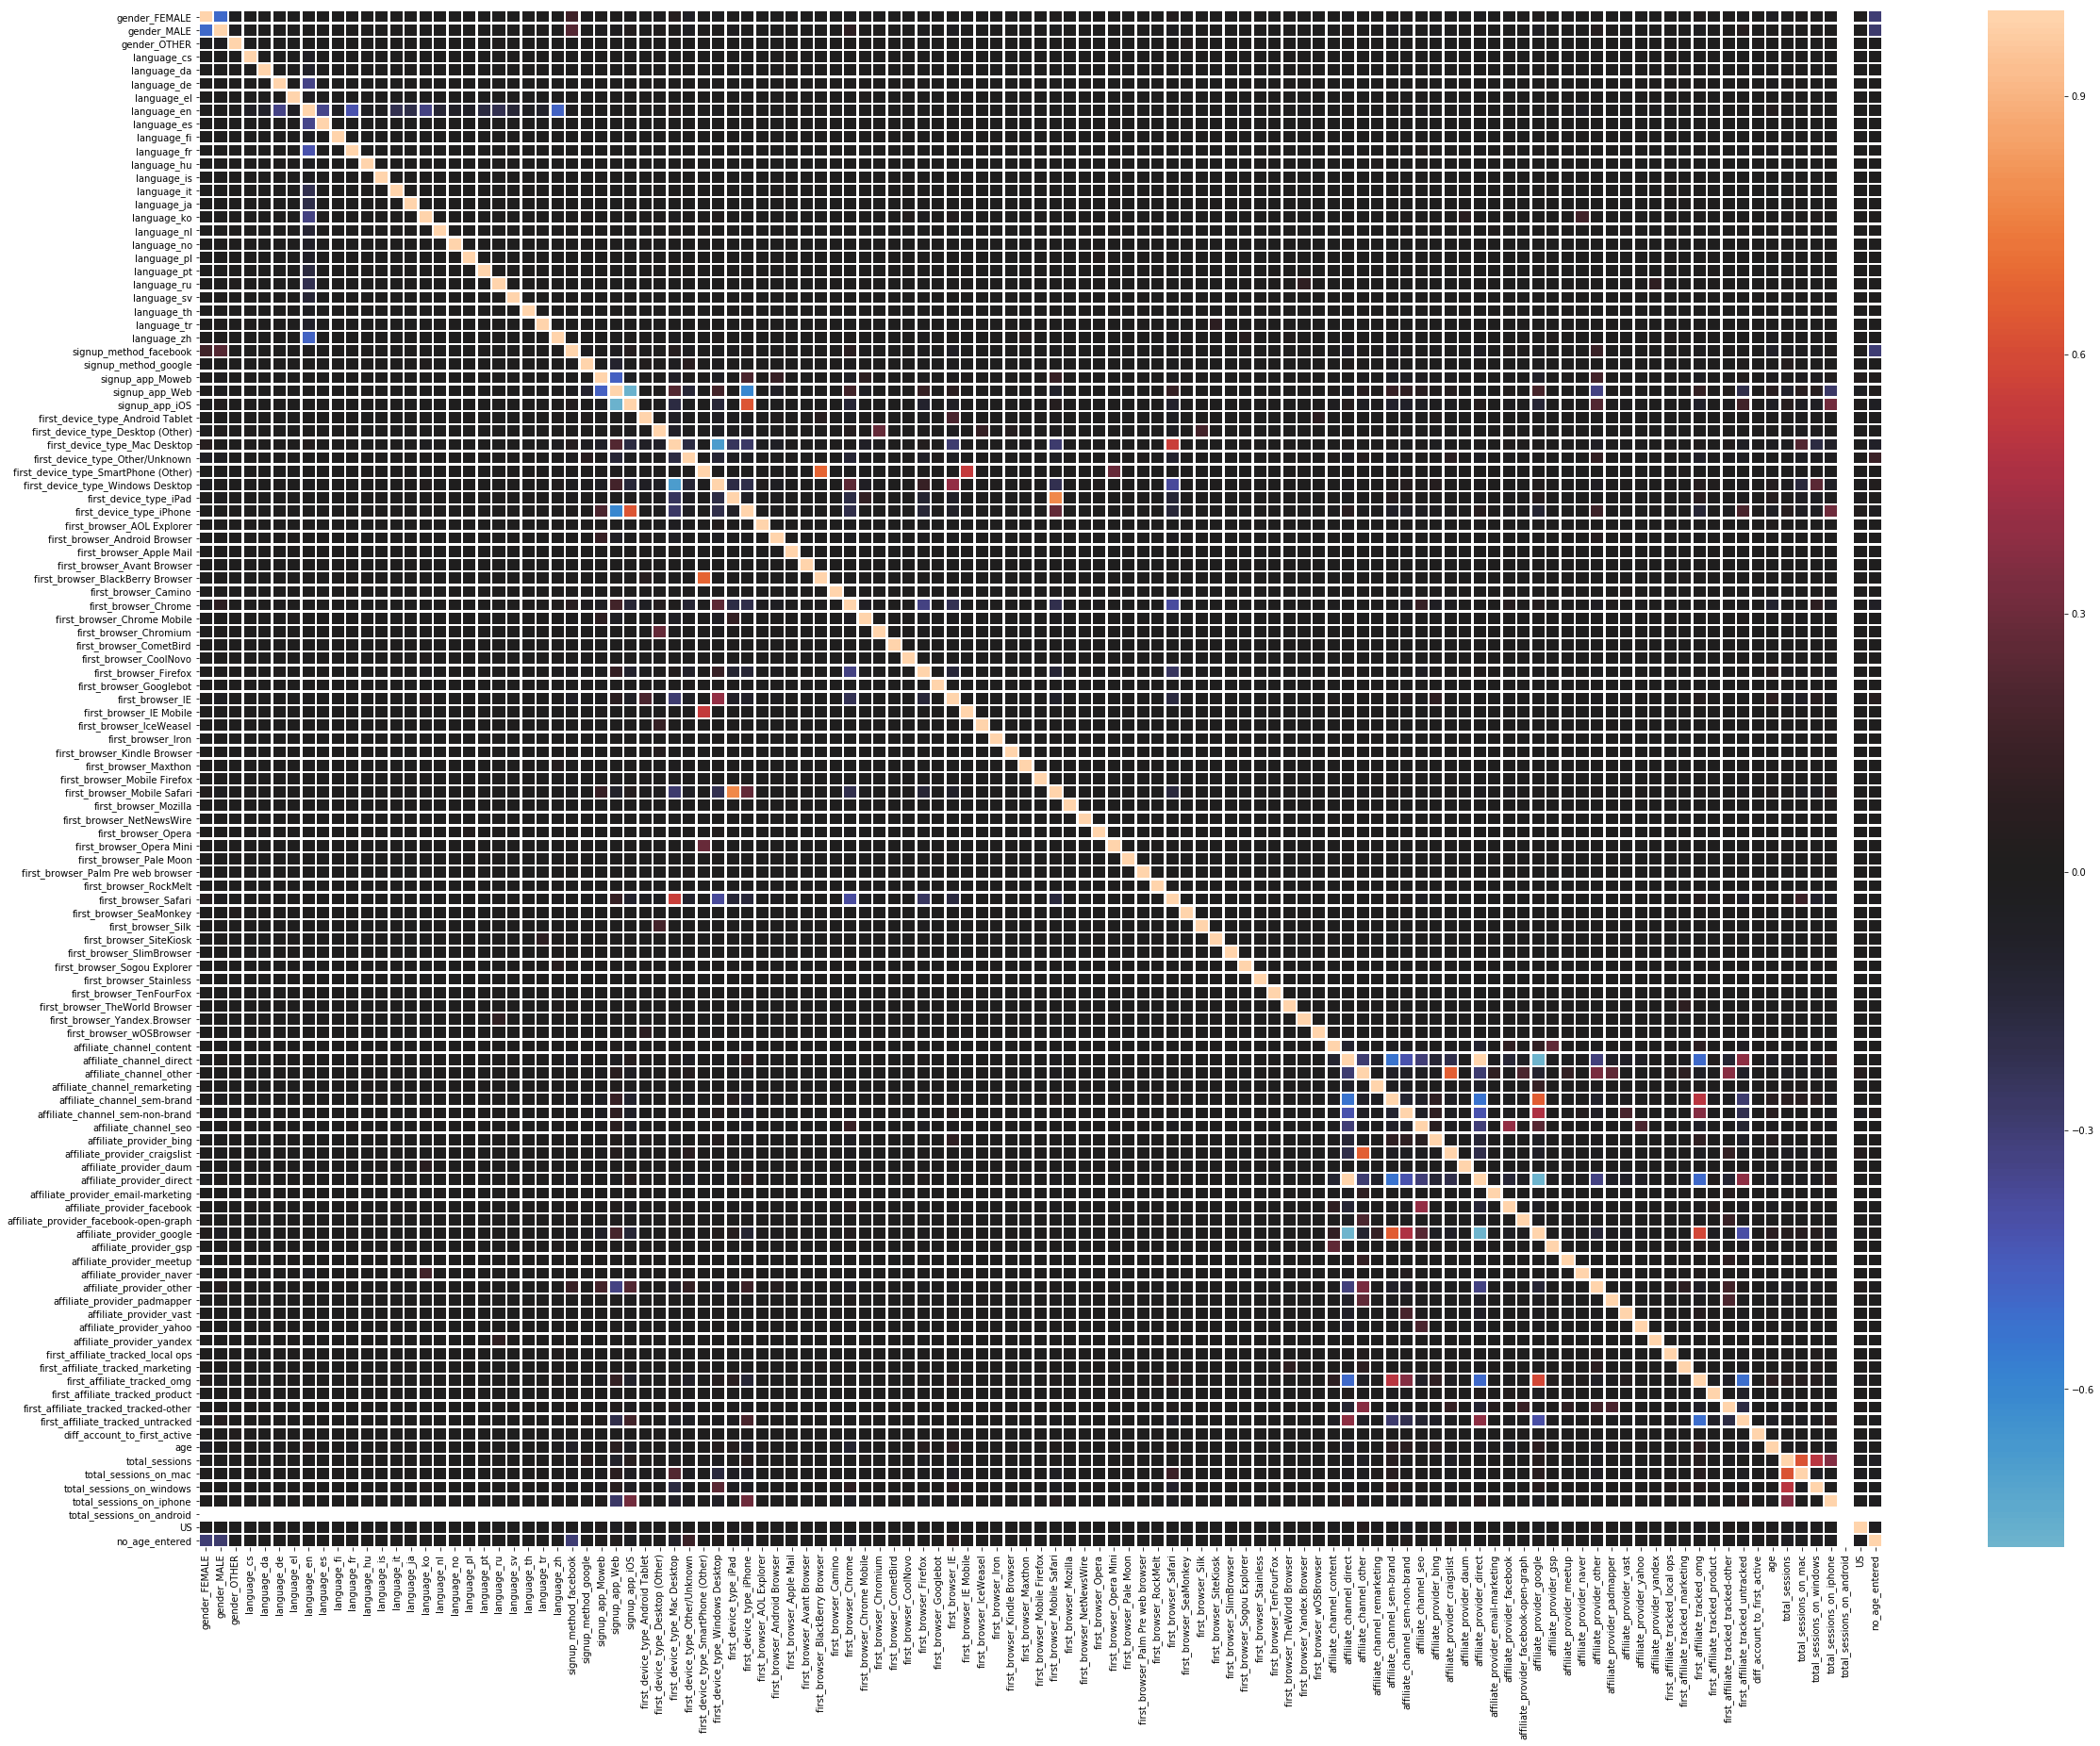

In [48]:
plt.figure(figsize = (40,30))
ax = sns.heatmap(users.corr(),  linewidths=1.5, center = 0)

In [44]:
import seaborn as sns